In [34]:
# import 所需的 library
import pandas as pd
import numpy as np
import miceforest as mf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# 不顯示 warning 訊息
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


plt.rcParams['font.sans-serif'] = ['Heiti TC']  
plt.rcParams['axes.unicode_minus'] = False  

## About data

資料來自[kaggle](https://www.kaggle.com/datasets/yasserhessein/multiclass-diabetes-dataset/data)，為糖尿病人的檢測資訊以及糖尿病患病狀態，共有264個病人，12個變數，變數說明如下：
1. Gender:個體的生理性別。通常編碼為：0 = 女性，1 = 男性。性別可能會因荷爾蒙和生活方式的差異影響糖尿病風險。    
2. AGE:個體的年齡。年齡是糖尿病風險的一個關鍵因素，尤其是 45 歲以上，隨著年齡增長風險會增加       
3. Urea:血液中尿素含量的測量 (單位: mg/dL)。高尿素水平可能表明腎臟問題，這是糖尿病常見的併發症。正常範圍：~7–20 mg/dL。      
4. Cr:測量血液中肌酐酸的水平 (單位: mg/dL)。也是腎臟功能的標誌物。肌酐酸水平升高可能表明腎功能受損，這通常與糖尿病有關。正常範圍：~0.6–1.3 mg/dL。        
5. HbA1c:一個關鍵指標，代表過去 2-3 個月內的平均血糖水平，以百分比表示。正常：<5.7% - 糖尿病前期：5.7–6.4% - 糖尿病：≥6.5%。     
6. Chol:血液中的總膽固醇含量。高膽固醇是心血管疾病的風險因素，通常在糖尿病患者中可見。正常：<200 mg/dL。     
7. TG:測量血液中脂肪的含量 (單位: mg/dL)。高水平與胰島素抵抗和代謝症候群有關。正常：<150 mg/dL。        
8. HDL:「好」膽固醇 (單位: mg/dL)。水平越高越好。它有助於清除血液中多餘的膽固醇。理想值：>40 mg/dL (男性)，>50 mg/dL (女性)。       
9. LDL:「壞」膽固醇 (單位: mg/dL)。高水平會導致斑塊積聚在動脈中。最佳值：<100 mg/dL。       
10. VLDL:另一種「壞」膽固醇 (單位: mg/dL)。主要攜帶三酸甘油酯。通常根據 TG/5 估算。高 VLDL 與糖尿病風險增加有關。正常：2–30 mg/dL。      
11. BMI:根據身高和體重測量身體脂肪 (單位: kg/m²)。肥胖 (BMI ≥30) 是第二型糖尿病的主要風險因素。正常：<18.5 – 體重過輕，18.5–24.9 – 體重正常，\
    25–29.9 – 超重，≥30 – 肥胖。    
13. Class:目標標籤，表示糖尿病狀態。通常編碼為：0 = 非糖尿病，1 = 糖尿病，2 = 糖尿病前期。這是您要預測或分類的結果。    

## Exploratory Data Analysis

載入資料集

In [35]:
df = pd.read_csv('/Users/wangyihong/Desktop/專案資料/糖尿病/Multiclass Diabetes Dataset.csv')

確認資料是否有缺失值

In [36]:
df.isnull().sum()

Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
Class     0
dtype: int64

資料並無缺失值，嘗試畫出資料間的關係。首先畫出不同Class間BMI的分佈，可以看出第2組的BMI分佈明顯與其他2組有明顯差異，糖尿病前期的BMI分佈集中在較高的值。

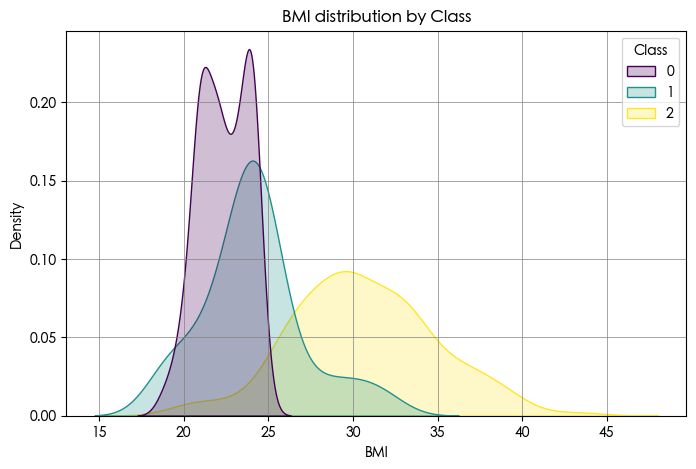

In [39]:
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')

sns.kdeplot(data=df, x='BMI', hue='Class', fill=True, palette='viridis', common_norm=False)

plt.xlabel("BMI")
plt.ylabel("Density")
plt.title("BMI distribution by Class")
plt.savefig('1-1', dpi=300, bbox_inches='tight')
plt.show()

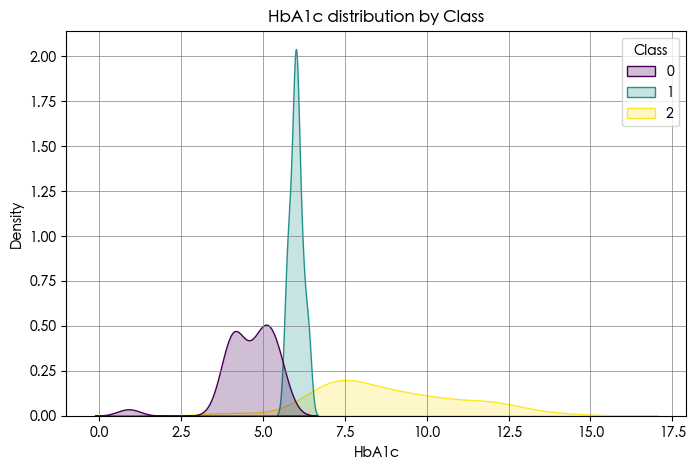

In [40]:
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')

sns.kdeplot(data=df, x='HbA1c', hue='Class', fill=True, palette='viridis', common_norm=False)

plt.xlabel("HbA1c")
plt.ylabel("Density")
plt.title("HbA1c distribution by Class")
plt.savefig('1-2', dpi=300, bbox_inches='tight')
plt.show()

接著再畫出不同Class間HbAlc的分佈，可以看出3組的BMI分佈都明顯與其他2組有明顯差異，對於分類糖尿病很可能來說為重要變數

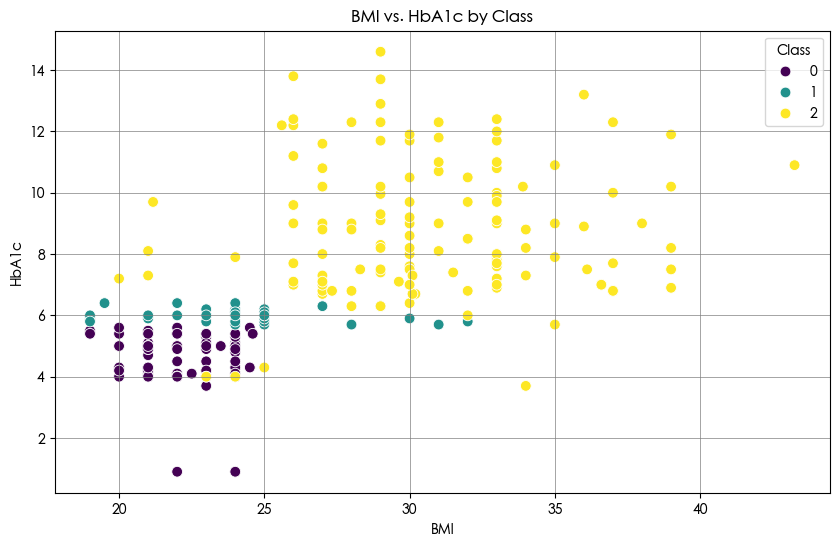

In [41]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')

sns.scatterplot(data=df, x='BMI', y='HbA1c', hue='Class', palette='viridis', s=60)

plt.title('BMI vs. HbA1c by Class')
plt.xlabel('BMI')
plt.ylabel('HbA1c')
plt.savefig('1-3', dpi=300, bbox_inches='tight')
plt.show()

最後畫出HbAlc與BMI的散佈圖並為不同Class加上不同顏色，可以看出Class可被這2個變數分割成功，接著我們建立分類預測模型

## Model construction

In [42]:
df[['Gender', 'Class']] = df[['Gender', 'Class']].astype('object')

編碼類別變數Gender

In [43]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_X = encoder.fit_transform(df[['Gender']])
encoded_df = pd.DataFrame(encoded_X, columns=encoder.get_feature_names_out(['Gender']))
df = pd.concat([df.drop(columns='Gender'), encoded_df], axis=1)
df = df.rename(columns = {'Gender_0':'female','Gender_1':'male'})

In [44]:
X = df.drop(columns='Class') ; y = df['Class'].astype(int)

分出訓練集與測試集

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

### Random forest

調控模型參數

In [46]:
rf_model = RandomForestClassifier(random_state=10069)

rf_param_grid = {
    'n_estimators': [30, 40, 50, 100, 150, 200],
    'max_depth': [2, 3, 5, 8, 10],
    'min_samples_split': [3, 5, 10, 15,]
}

rf_grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=rf_param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1,
        verbose=1
)

rf_grid_search.fit(X_train, y_train) 
print("\n最佳參數:", rf_grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

最佳參數: {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 100}


以最佳參數訓練模型，並觀察預測結果

In [47]:
best_rf_model = rf_grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)
print("\n最佳模型在測試集上的分類報告：")
print(classification_report(y_test, y_pred))


最佳模型在測試集上的分類報告：
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.92      0.96        12
           2       0.97      0.95      0.96        39

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



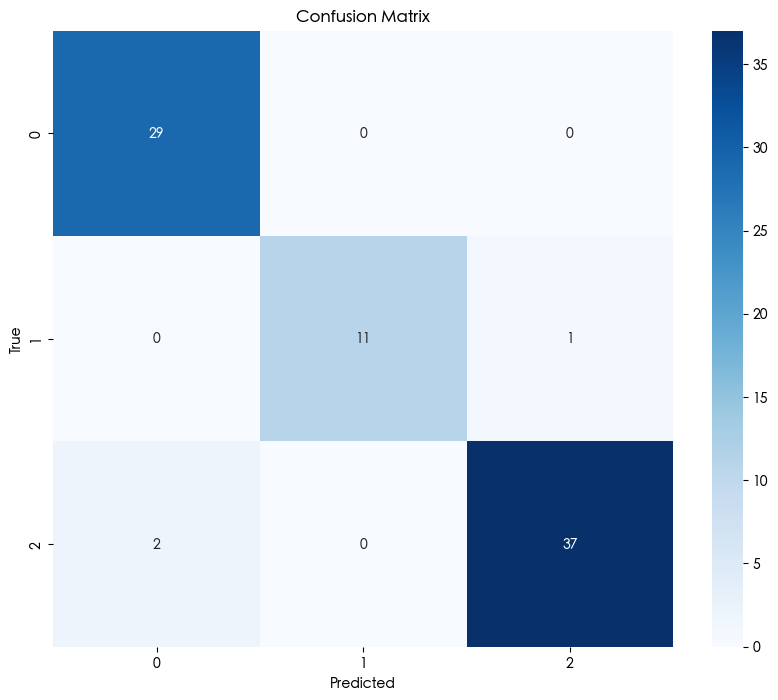

In [48]:
cm = confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(y))), yticklabels=range(len(set(y))))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('1-4', dpi=300, bbox_inches='tight')
plt.show()

模型表現良好，預測有96%的準確率，只有2個樣本預測錯誤，對於糖尿病(Class = 1)的預測準確度為100%。接著畫出Random forest的變數重要程度。

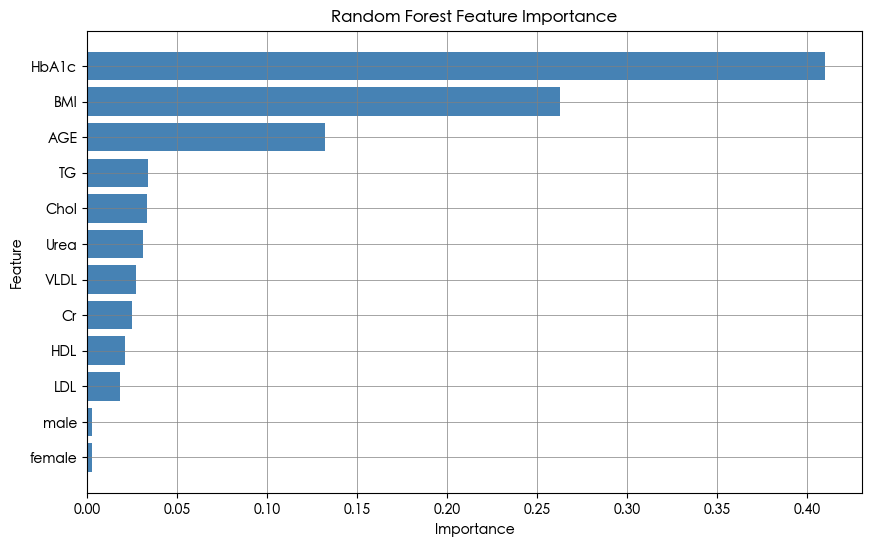

In [49]:
feature_importances = best_rf_model.feature_importances_

# 將特徵名稱和重要性配對
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance')


# --- 繪製特徵重要性圖表 ---
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.savefig('1-5', dpi=300, bbox_inches='tight')
plt.show()

如同前面Exploratory Data Analysis的結果，糖尿病的分類預測基本上可由2個變數HbAlc與BMI決定。

為了更詳細的看出Random forest如何根據變數分類，畫出模型的PartialDependenceDisplay觀察

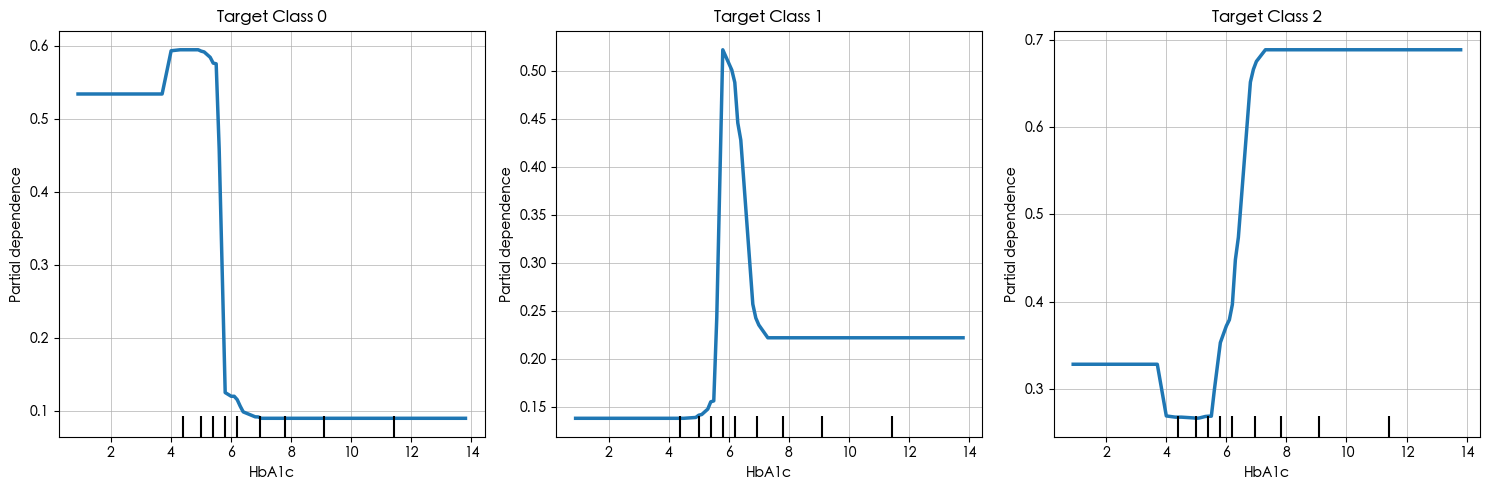

In [50]:
classes_to_plot = [0, 1, 2]
fig, axes = plt.subplots(ncols=len(classes_to_plot), figsize=(15, 5))

for i, target_class in enumerate(classes_to_plot):
    PartialDependenceDisplay.from_estimator(
        estimator=best_rf_model,
        X=X_test,
        features=['HbA1c'],
        target=target_class,  # 傳入單一的目標索引
        ax=axes[i],
        pd_line_kw={"linewidth": 2.5}
    )
    axes[i].set_title(f'Target Class {target_class}')

for sub_ax in fig.axes:
    sub_ax.grid(True, which='both', linewidth=0.5)

plt.tight_layout()
plt.savefig('1-6', dpi=300, bbox_inches='tight')
plt.show()

y軸為屬於該類別的機率，綜合3張圖來觀察，可以看到HbAlc值在5以下時，被模型判斷為無糖尿病(Class = 0)的機率增加，HbAlc值在5至8時，被模型判斷為糖尿病(Class = 1)的機率增加，在HbAlc值在8以上時，被模型判斷為糖尿病前期(Class = 2)的機率增加。

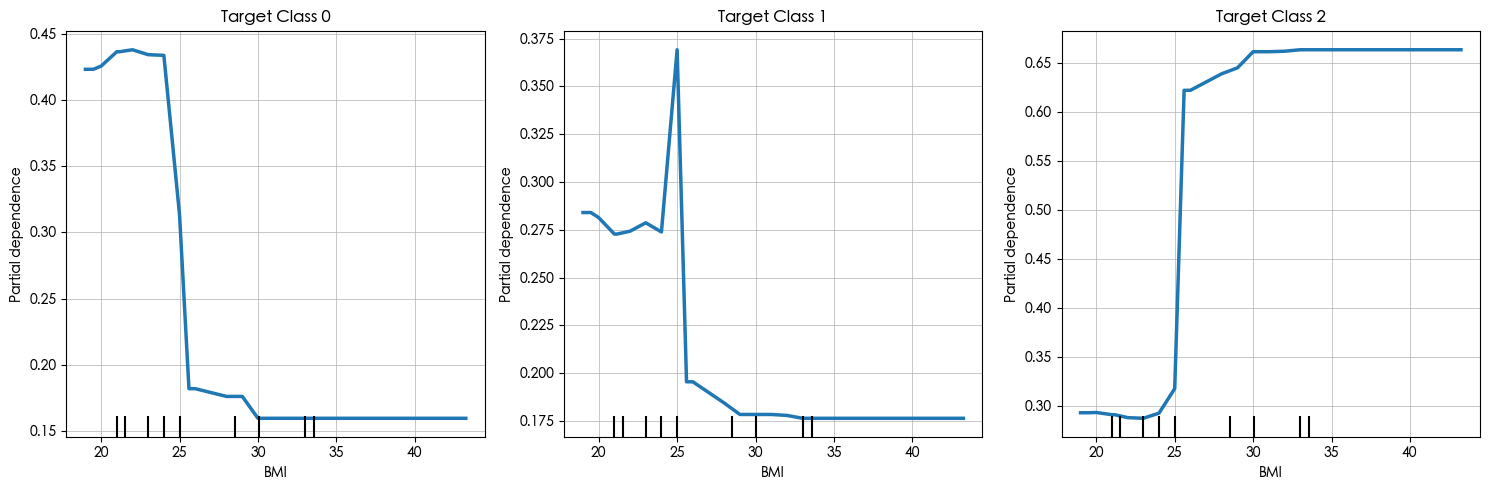

In [51]:
fig, axes = plt.subplots(ncols=len(classes_to_plot), figsize=(15, 5))

for i, target_class in enumerate(classes_to_plot):
    PartialDependenceDisplay.from_estimator(
        estimator=best_rf_model,
        X=X_test,
        features=['BMI'],
        target=target_class,  # 傳入單一的目標索引
        ax=axes[i],
        pd_line_kw={"linewidth": 2.5}
    )
    axes[i].set_title(f'Target Class {target_class}')

for sub_ax in fig.axes:
    sub_ax.grid(True, which='both', linewidth=0.5)

plt.tight_layout()
plt.savefig('1-7', dpi=300, bbox_inches='tight')
plt.show()

同樣綜合3張圖來觀察，可以看到BMI值在25以下時，被模型判斷為無糖尿病(Class = 0)的機率增加，BMI值在25附近時，被模型判斷為糖尿病(Class = 1)的機率增加，在BMI值在25以上時，被模型判斷為糖尿病前期(Class = 2)的機率增加。

### Xgboost

接著建立Xgboost模型，調控模型參數

In [52]:
num_classes = len(set(y_train))

xgb_model_1 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,    
    random_state=42
)

param_test_1 = {
 'max_depth':range(2,10,1),
 'min_child_weight':range(1,6,1)
}

grid_search_1 = GridSearchCV(
    estimator=xgb_model_1,
    param_grid=param_test_1,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train)
grid_search_1.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'max_depth': 2, 'min_child_weight': 4}

In [53]:
xgb_model_2 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=grid_search_1.best_params_['max_depth'],
    min_child_weight=grid_search_1.best_params_['min_child_weight'],
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,    
    random_state=42
)

param_test_2 = {
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5,0.6,0.7, 0.8, 0.9, 1.0]
}

grid_search_2 = GridSearchCV(
    estimator=xgb_model_2,
    param_grid=param_test_2,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train)
grid_search_2.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


{'colsample_bytree': 0.5, 'gamma': 0.0, 'subsample': 0.7}

In [54]:
xgb_model_3 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=grid_search_1.best_params_['max_depth'],
    min_child_weight=grid_search_1.best_params_['min_child_weight'],
    gamma=grid_search_2.best_params_['gamma'],
    subsample=grid_search_2.best_params_['subsample'],
    colsample_bytree=grid_search_2.best_params_['colsample_bytree'],    
    random_state=42
)

param_test_3= {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1,10]
}

grid_search_3 = GridSearchCV(
    estimator=xgb_model_3,
    param_grid=param_test_3,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train)
grid_search_3.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'reg_alpha': 0}

以最佳參數建立模型

In [55]:
xgb_final_params = {
    'n_estimators': 5000,
    'learning_rate': 0.05,  
    'objective':'multi:softmax',
    'num_class':num_classes,
    'eval_metric':'mlogloss',
    **grid_search_1.best_params_,
    **grid_search_2.best_params_,
    **grid_search_3.best_params_
}

xgb_final_model = xgb.XGBClassifier(**xgb_final_params)
xgb_final_model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


驗證模型分類結果

In [56]:
y_pred = xgb_final_model.predict(X_test)
print("\n最佳模型在測試集上的分類報告：")
print(classification_report(y_test, y_pred))


最佳模型在測試集上的分類報告：
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       0.92      1.00      0.96        12
           2       1.00      0.92      0.96        39

    accuracy                           0.96        80
   macro avg       0.95      0.97      0.96        80
weighted avg       0.97      0.96      0.96        80



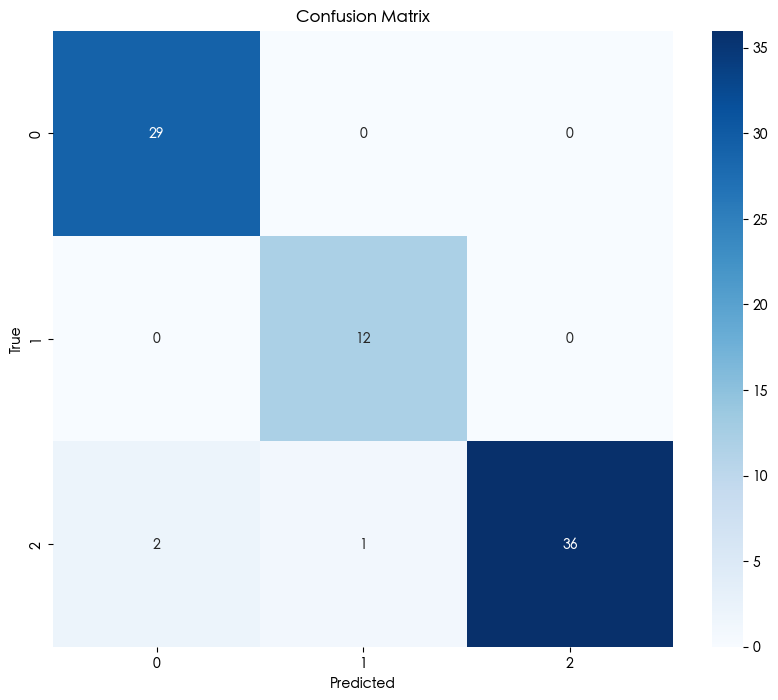

In [57]:
cm = confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(set(y))), yticklabels=range(len(set(y))))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('1-8', dpi=300, bbox_inches='tight')
plt.show()

Xgboost模型同樣表現良好，同樣有96%的準確率，只有3個樣本預測錯誤，對於糖尿病前期(Class = 2)的預測準確度為100%。接著排序出Xgboost模型的變數重要程度。

<Figure size 1000x800 with 0 Axes>

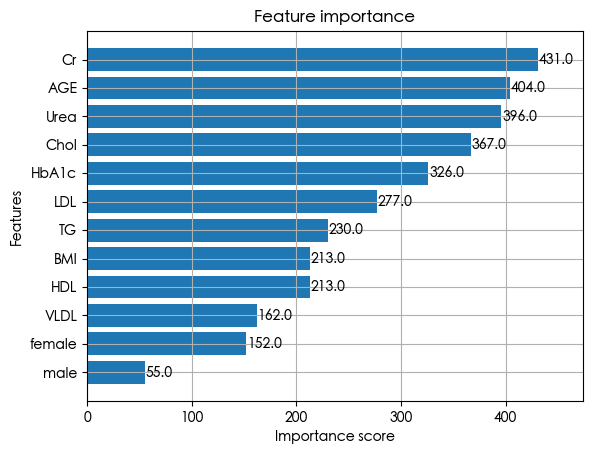

In [59]:
plt.figure(figsize=(10, 8)) 

# 繪製特徵重要性圖表
plot_importance(xgb_final_model, height=0.8)
plt.savefig('1-9', dpi=300, bbox_inches='tight')
# 顯示圖表
plt.savefig('1-9', dpi=300, bbox_inches='tight')
plt.show()

與Random forest模型的不同，重要的變數排序不同，並且並無展現出顯著的重要性差異。

## Conclusion

根據上述模型訓練結果，可總結以下幾點結論：
1. Random forest 模型判定的前3名重要變數為：HbA1c，BMI，AGE，並且明顯比其他變數重要許多
2. Xgboost 模型判定的前3名重要變數為：Cr，AGE，Urea
3. 從散佈圖可看出糖尿病的類別預測基本上可由2個變數HbA1c，BMI分割

糖尿病預測分析就到這裡，謝謝大家觀看